In [7]:
from fonduer.supervision import Labeler
from fonduer.features import Featurizer
from fonduer.candidates.models import Candidate

from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import LabelModel

from pipeline.utils import get_session, load_candidates
from definitions.candidates import NameFullAbbr, NameFullTask

Get session object

In [4]:
session = get_session(db_name="test_collection")

[2023-04-30 10:43:54,990][INFO] fonduer.meta:49 - Setting logging directory to: /tmp/2023-04-30_10-43-54


Define candidates and Labeler object

In [5]:
candidates = [NameFullTask, NameFullAbbr]
labeler = Labeler(session, candidates)

Load candidates and labels

In [19]:
train_cands = load_candidates(session, 0, candidates)
L_train_NFT, L_train_NFA = labeler.get_label_matrices(train_cands) # NFT --> NameFullTask, NFA --> NameFullAbbr

/workspaces/bio-medRxiv/pipeline/utils.py:39: SAWarning: Coercing Subquery object into a select() for use in IN(); please pass a select() construct explicitly
  cands = (session.query(candidate_class).filter(candidate_class.id.in_(sub_query)).order_by(candidate_class.id).all())


List of models

| Modelname | description | n_epochs |
| --------- | ----------- | -------- |
| label_model_v1 | label model with random label functions | 500 |

In [26]:
from pathlib import Path

gen_model_NFT = LabelModel(cardinality=2)
gen_model_NFA = LabelModel(cardinality=2)


if Path("models/label_model_NFA_v1.pkl").is_file() and Path("models/label_model_NFT_v1.pkl").is_file():
    gen_model_NFA.load(source="models/label_model_NFA_v1.pkl")
    gen_model_NFT.load(source="models/label_model_NFT_v1.pkl")
    print("Loaded Models")
else:
    gen_model_NFT.fit(L_train_NFT, n_epochs=500, log_freq=100)
    gen_model_NFT.save("models/label_model_NFT_v1.pkl")

    gen_model_NFA.fit(L_train_NFA, n_epochs=500, log_freq=100)
    gen_model_NFA.save("models/label_model_NFA_v1.pkl")
    print("Fit and saved models")

Loaded Models


In [27]:
train_marginals_NFA = gen_model_NFA.predict_proba(L_train_NFA)
train_marginals_NFT = gen_model_NFT.predict_proba(L_train_NFT)

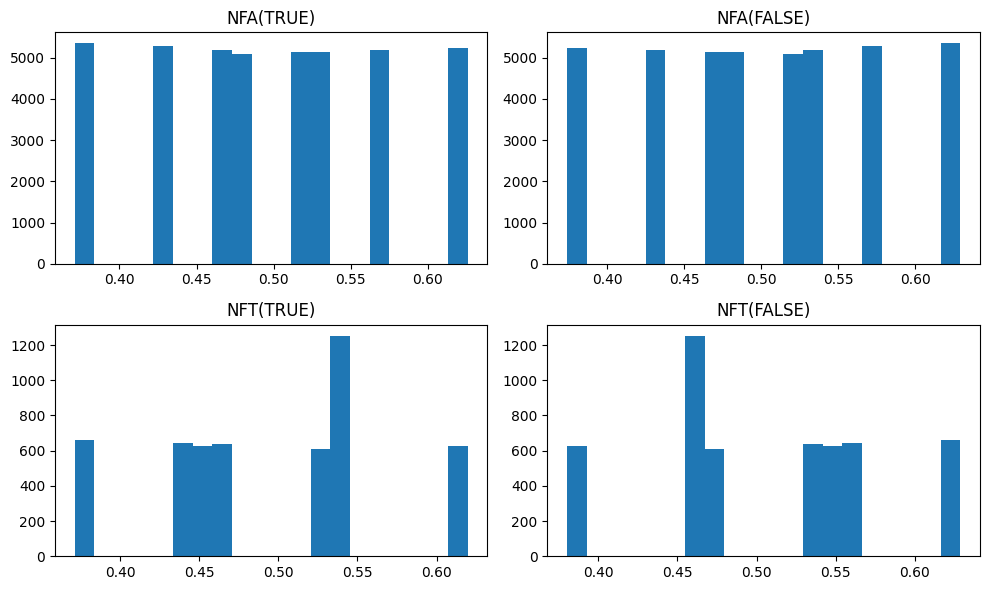

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.set_tight_layout("w_pad")

bins=20

ax[0, 0].hist(train_marginals_NFA[:, 0], bins=bins)
ax[0, 0].set_title("NFA(TRUE)")
ax[0, 1].hist(train_marginals_NFA[:, 1], bins=bins)
ax[0, 1].set_title("NFA(FALSE)")

ax[1, 0].hist(train_marginals_NFT[:, 0], bins=bins)
ax[1, 0].set_title("NFT(TRUE)")
ax[1, 1].hist(train_marginals_NFT[:, 1], bins=bins)
ax[1, 1].set_title("NFT(FALSE)")
plt.show()